# Multiclass text classification using BERT
- toc: true
- badges: true
- categories: [Natural Language Processing, Hugging Face]
- permalink: /bert-multiclass-text-classification/
- description: a tutorial on mult-class text classfication using pretrained BERT model from HuggingFace

In this post, we'll do a simple text classification task using the pretained [BERT model]((https://huggingface.co/docs/transformers/model_doc/bert) from HuggingFace.

The BERT model was proposed in [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805), by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova.


In [ ]:
#hide
!pip install transformers
import pandas as pd


In [ ]:
#hide
import warnings
warnings.filterwarnings("ignore")

## Loading data



In [1]:

PRETRAINED_LM = "bert-base-uncased"
%mkdir PRI_EN
TB_path="/content/PRI_EN"
import pandas as pd


In [2]:
BATCH_SIZE = 128


In [3]:
def build_data(in_file,POS):

    import csv

    max_length=0

    # Open the input file in read mode
    input_file = open(in_file+".conllu", "r")

    # Create an empty list to store the lines
    words = ""
    root= ""
    csv_line=[]



    with open(in_file+".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["text","label"])
        root_found=False
        # Loop through each line in the input file
        c=0
        for line in input_file:

          if line!="\n":
                words=words+(line.split()[1])+" "
                if line.split()[6]=="0" and not root_found:
                  root=POS[line.split()[3]]
                  root_found=True

          else:
                c+=1
                full_text=words[0:-1]
                root_found=False
                if len(words)>max_length: max_length= len(words.split(" "))
                csv_line.append(full_text)
                csv_line.append(str(root))
                writer.writerow(csv_line)


                csv_line=[]
                words = ""
                root= ""

    print('max_length',max_length,"\n","count of examples:",c)
    # Close the input file
    input_file.close()




In [9]:

POS={}
label_names=set()

for f in ["train","dev","test"]:
   temp_pos=set()
   input_file = open(f+".conllu", "r")
   for line in input_file:
    if line!="\n":
      if line.split()[6]=="0":
        label_names.add(line.split()[3])
        temp_pos.add(line.split()[3])
   print(f,len(temp_pos),"\n",temp_pos)

label_names=list(label_names)
for i in range(len(label_names)):
  POS[label_names[i]]=i



build_data("/content/train",POS)
build_data("/content/dev",POS)
build_data("/content/test",POS)


N_labels = len(label_names)
print(POS)
print(label_names)
print("N_labels: ",N_labels)

train_df=pd.read_csv("train.csv")
valid_df=pd.read_csv("dev.csv")
test_df=pd.read_csv("test.csv")

def count_pos(df,df_name):
    print("\n ---", df_name,"---\n")
    for i in range(N_labels):
        counter = len(df.loc[df['label'] == i])
        print(i,counter)

count_pos(train_df,"train")
count_pos(valid_df,"dev")
count_pos(test_df,"test")

train 15 
 {'PRON', 'SYM', 'NUM', 'AUX', 'ADV', 'CCONJ', 'PART', 'PUNCT', 'VERB', 'ADJ', 'NOUN', 'X', 'PROPN', 'DET', 'INTJ'}
dev 14 
 {'PRON', 'SYM', 'ADV', 'AUX', 'PART', 'PUNCT', 'DET', 'VERB', 'ADJ', 'NOUN', 'X', 'PROPN', 'NUM', 'INTJ'}
test 13 
 {'PRON', 'SYM', 'ADV', 'AUX', 'PUNCT', 'DET', 'VERB', 'ADJ', 'NOUN', 'X', 'PROPN', 'NUM', 'INTJ'}
max_length 27 
 count of examples: 12544
max_length 13 
 count of examples: 2001
max_length 21 
 count of examples: 2077
{'PRON': 0, 'SYM': 1, 'NUM': 2, 'AUX': 3, 'ADV': 4, 'CCONJ': 5, 'PART': 6, 'PUNCT': 7, 'VERB': 8, 'ADJ': 9, 'NOUN': 10, 'X': 11, 'PROPN': 12, 'DET': 13, 'INTJ': 14}
['PRON', 'SYM', 'NUM', 'AUX', 'ADV', 'CCONJ', 'PART', 'PUNCT', 'VERB', 'ADJ', 'NOUN', 'X', 'PROPN', 'DET', 'INTJ']
N_labels:  15

 --- train ---

0 89
1 103
2 367
3 24
4 187
5 1
6 2
7 41
8 7269
9 1263
10 1907
11 165
12 1026
13 20
14 80

 --- dev ---

0 18
1 13
2 22
3 4
4 31
5 0
6 1
7 14
8 1008
9 221
10 454
11 34
12 156
13 4
14 21

 --- test ---

0 22
1 8
2 31
3 4

In [ ]:
train_df.head()

,text,label
0,Al - Zaman : American forces killed Shaikh Abd...,6
1,[ This killing of a respected cleric will be c...,14
2,DPA : Iraqi authorities announced that they ha...,6
3,Two of them were being run by 2 officials of t...,14
4,"The MoI in Iraq is equivalent to the US FBI , ...",5


## Tokenization

Tokenization is a process for spliting raw texts into tokens, and encoding the tokens into numeric data.

To do this, we first initialize a `BertTokenizer`:

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

define a function for encoding:

In [ ]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

Use the `ecode` function to get input ids and attention masks of the datasets:

In [ ]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid_df['text'].values.tolist())
test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())

<br>

## Creating `Dataset`s and `DataLoader`s

We'll use pytorch `Dataset` and `DataLoader` to split data into batches. For more detatils, you can check out another post on [DataLoader](https://www.intodeeplearning.com/how-to-load-datasets-from-hugging-face-datasets/).

Turn the labels into tensors:

In [ ]:
import torch
train_y = torch.LongTensor(train_df['label'].values.tolist())
valid_y = torch.LongTensor(valid_df['label'].values.tolist())
test_y = torch.LongTensor(test_df['label'].values.tolist())
train_y.size(),valid_y.size(),test_y.size()

(torch.Size([12544]), torch.Size([2001]), torch.Size([2077]))

Create dataloaders for training

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

<br>

## Bert For Sequence Classification Model

We will initiate the  `BertForSequenceClassification ` model from Huggingface, which allows easily fine-tuning the pretrained BERT mode for classification task.


You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained.

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.cuda()

<br>

## Fine-tuning

### **Optimizer and Scheduler**

An **optimizer** is for tuning parameters in the model, which is set up with a learning rate.

Selection of the learning rate is important. In practice, it's common to use a **scheduler** to decrease the learning rate during training.

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 30
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

<br>

### **Training Loop**

The training loop is where the magic of deep learning happens. The model will be fine-tuned on the emotion dataset for classification task.

In [ ]:
#collapse-output
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 2.3356329859519493 
16/16 val loss: 2.024774417281151 
Epoch:  2


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 1.6448493490413743 
16/16 val loss: 1.5233018472790718 
Epoch:  3


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 1.3028128049811538 
16/16 val loss: 1.2892205342650414 
Epoch:  4


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 1.1322850159236364 
16/16 val loss: 1.1444321759045124 
Epoch:  5


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 1.0045683031179466 
16/16 val loss: 1.0231117084622383 
Epoch:  6


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.8987603078083116 
16/16 val loss: 0.9230580739676952 
Epoch:  7


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.8133242878378654 
16/16 val loss: 0.8418938219547272 
Epoch:  8


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.7404091644043825 
16/16 val loss: 0.7764836736023426 
Epoch:  9


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.6758338906327073 
16/16 val loss: 0.7149573098868132 
Epoch:  10


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.6217614068668715 
16/16 val loss: 0.668210769072175 
Epoch:  11


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.5725884027018839 
16/16 val loss: 0.626570513471961 
Epoch:  12


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.5335444798883127 
16/16 val loss: 0.5901498012244701 
Epoch:  13


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.4919156675436059 
16/16 val loss: 0.559112373739481 
Epoch:  14


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.4583110757628266 
16/16 val loss: 0.5361257921904325 
Epoch:  15


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.42996096671844014 
16/16 val loss: 0.5129536371678114 
Epoch:  16


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.40935804436401446 
16/16 val loss: 0.4970565140247345 
Epoch:  17


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.3921944599370567 
16/16 val loss: 0.48175711929798126 
Epoch:  18


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.3718948751992109 
16/16 val loss: 0.47062212973833084 
Epoch:  19


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.3587767332792282 
16/16 val loss: 0.45889194868505 
Epoch:  20


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.3445949704975498 
16/16 val loss: 0.45534054562449455 
Epoch:  21


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.33305440371742057 
16/16 val loss: 0.44417770579457283 
Epoch:  22


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.3241055045200854 
16/16 val loss: 0.44181687012314796 
Epoch:  23


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.31998276147915394 
16/16 val loss: 0.4346137084066868 
Epoch:  24


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.31360583083362 
16/16 val loss: 0.4307264853268862 
Epoch:  25


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.30306879195327663 
16/16 val loss: 0.4253036715090275 
Epoch:  26


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.3017428813844311 
16/16 val loss: 0.4230262041091919 
Epoch:  27


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.2956432964728803 
16/16 val loss: 0.42125279083848 
Epoch:  28


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.29570167633343714 
16/16 val loss: 0.4211462065577507 
Epoch:  29


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.2928811904727196 
16/16 val loss: 0.42002577520906925 
Epoch:  30


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

98/98 train loss: 0.2882137789714093 
16/16 val loss: 0.4197596237063408 


You can see in the output that the training and validation losses steadily decreases in each epoch.

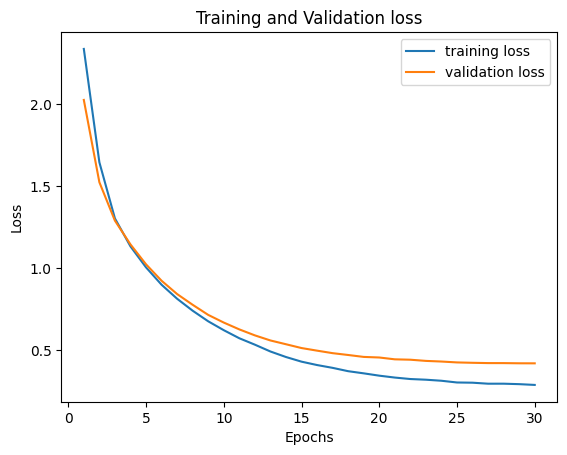

In [ ]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

## Performance Metrics
It's common to use precision, recall, and F1-score as the performance metrics.

In [ ]:
from sklearn.metrics import classification_report
#print('classifiation report')
#print(classification_report(valid_pred, valid_df['label'].to_numpy(), target_names=label_names))

## Error Analysis
With the predictions, we can plot the confusion matrix:

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

In [ ]:
#plot_confusion_matrix(valid_pred,valid_df['label'].to_numpy(),labels=label_names)

You can see that **sadness** has a higher likelihood to be classified as **anger** or **fear**, leading to a lower f1 score.

<br>

## Prediction

*Now* let's use the trained model to predict the testing set.

In [ ]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [ ]:
from sklearn.metrics import classification_report,accuracy_score
print('classifiation report\n')
print("pos count_in_pred")

for pos in set(test_pred):
  print(label_names[pos],list(test_pred).count(pos))
print("\n\npos count_in_test")
for pos in set(test_df['label'].to_numpy()):
  print(label_names[pos],list(test_df['label'].to_numpy()).count(pos))

print("\n\n Accuracy: ",round(accuracy_score(test_pred, test_df['label'].to_numpy())*100,2))
print(classification_report(test_pred, test_df['label'].to_numpy(),target_names=label_names))

classifiation report

pos count_in_pred
PUNCT 1
NOUN 452
SYM 5
ADJ 235
PROPN 266
X 34
INTJ 38
NUM 20
VERB 1026


pos count_in_test
PUNCT 31
NOUN 410
DET 2
AUX 4
SYM 8
ADJ 226
PROPN 237
X 39
ADV 30
INTJ 26
NUM 31
PRON 22
VERB 1011


 Accuracy:  88.88


ValueError: ignored

With the predictions, we can plot the confusion matrix again:

ValueError: ignored

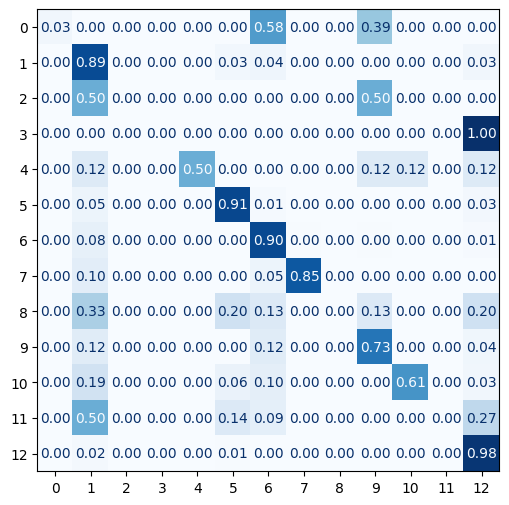

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
plot_confusion_matrix(test_pred,test_df['label'].to_numpy(),labels=label_names)

Output the misclassified text:

In [ ]:
test_df['pred'] = test_pred
test_df.reset_index(level=0)
print(test_df[test_df['label']!=test_df['pred']].shape)
test_df[test_df['label']!=test_df['pred']][['text','label','pred']].head(10)

(231, 3)


,text,label,pred
0,What if Google Morphed Into GoogleOS ?,12,14
1,What if Google expanded on its search - engine...,12,14
2,[ via Microsoft Watch from Mary Jo Foley ],6,1
3,"( And , by the way , is anybody else just a li...",1,5
18,This Fallujah operation my turn out to be the ...,14,1
63,"Most troubling , however , is the fact that th...",1,5
65,"Two weeks later , and the violence continues .",8,14
66,The African Union is clearly not up to the tas...,1,5
79,i.e .,7,6
91,...,4,9


In [ ]:
#hide

test_df.to_csv(TB_path+"/test_results.csv",index= False)
valid_df.to_csv(TB_path+"/dev_results.csv",index= False)

In [ ]:

from google.colab import files
%cd /content/





!zip -r PRI_EN.zip PRI_EN
files.download('PRI_EN.zip')


/content
  adding: PRI_EN/ (stored 0%)
  adding: PRI_EN/dev_results.csv (deflated 59%)
  adding: PRI_EN/test_results.csv (deflated 60%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>